In [22]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import copy
import torch.nn as nn
import shap
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

import sys
sys.path.insert(1, '../../models/Multi-Body')
from multidataset import MultiDataset
from multimodel import Net as Model


In [23]:
#Parameters to change, can change model_type to 'best' or 'last'
use_jet_pt = True
use_jet_mass = True
tau_x_1 = False
N = 8
model_type = 'best'
extra_name = ''
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

if tau_x_1:
    extra_name = 'tau_x_1'
#Testing path
test_path = '../../datasets/n-subjettiness_data/test_all.npy'

#model path
model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

#loading model
model = Model(N, use_jet_pt, use_jet_mass, tau_x_1).cuda()
model.load_state_dict(torch.load(model_path))
model.eval()

Net(
  (dense1): Linear(in_features=22, out_features=200, bias=True)
  (dense2): Linear(in_features=200, out_features=200, bias=True)
  (dense3): Linear(in_features=200, out_features=50, bias=True)
  (dense4): Linear(in_features=50, out_features=50, bias=True)
  (dense5): Linear(in_features=50, out_features=2, bias=True)
  (relu): ReLU()
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (softmax): Softmax(dim=1)
)

In [24]:
#Loading testing dataset
test_set = MultiDataset(test_path, N, use_jet_pt, use_jet_mass, tau_x_1)
feat_names = []
if not tau_x_1:
    for i in range(N-1):
        if i != N-2:
            feat_names.append('tau_'+str(i+1)+'_'+str(0.5))
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
        else:
            feat_names.append('tau_'+str(i+1)+'_'+str(1))
            feat_names.append('tau_'+str(i+1)+'_'+str(2))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
else:
    for i in range(N-1):
        feat_names.append('tau_'+str(i+1)+'_'+str(1))
    if use_jet_pt:
        feat_names.append('jet_pt')
    if use_jet_mass:
        feat_names.append('jet_mass')
layer_names = ['dense1', 'relu', 'dropout2', 'dense2', 'relu', 'dropout2', 'dense3', 'relu', 
              'dropout1', 'dense4', 'relu', 'dropout1', 'dense5', 'softmax']
data,labels = test_set[:]
full_data = np.concatenate((data,labels),axis=1)
df_test = pd.DataFrame(full_data, columns=np.append(feat_names, ['background_prob', 'signal_prob']))
feats = df_test.drop(columns=['background_prob', 'signal_prob'])
means = np.array(df_test.mean(0))

In [25]:
def NeuronFiringEvaluator(model, x):
    data = torch.tensor(x, dtype = torch.float32).cuda()
    FiringEvaluator = []
    layer_tags = []
    with torch.no_grad():
        model.eval()
        data = model.dense1(data)
        data = model.relu(data)
        data = model.dropout2(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 1')
    
        data = model.dense2(data)
        data = model.relu(data)
        data = model.dropout2(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 2')

        data = model.dense3(data)
        data = model.relu(data)
        data = model.dropout1(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 3')

        data = model.dense4(data)
        data = model.relu(data)
        data = model.dropout1(data)
        FiringEvaluator.append(data.cpu().numpy().sum(0))
        layer_tags.append('Layer 4')

        data = model.dense5(data)
        presoftmax = data.cpu().numpy()
        data = model.softmax(data)
        result = data.cpu().numpy()
    return FiringEvaluator, layer_tags
        
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline', save=False):
    tag = 'baseline' if tag == ''else tag.strip('_')
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    print(N_cols, N_rows)
    Nnodes = 0
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
        Nnodes += len(FiringMatrix_0[ii])
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)
    s0 = np.sum(FiringMatrix_0 < 0.2)/Nnodes
    s1 = np.sum(FiringMatrix_1 < 0.2)/Nnodes
    sall = np.sum(np.maximum(FiringMatrix_0, FiringMatrix_1) < 0.2)/Nnodes
    print("Sparsity measure (RNA < 0.2) for background jets: ", s0)
    print("Sparsity measure (RNA < 0.2) for signal jets: ", s1)
    print("Overall sparsity measure (RNA < 0.2): ", sall)
    ## The relative node firing rates for class 0 are multiplied by a factor of -1
    ## to represent the NAPs of two classes side by side for a visual comparison
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes.set_facecolor('grey')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_xlabel('Network Activation Layers', fontsize = 40)
    axes.set_ylabel('Node in hidden layer', fontsize = 40)
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical',  fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/NAP_MB8S_{}.png".format(tag))
    plt.show()
    
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=40) 
    axes.set_facecolor('grey')
    axes.set_xlabel('Network Activation Layers', fontsize=40)
    axes.set_ylabel('Node in hidden layer', fontsize=40)
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical', fontsize=40)
    axes.tick_params(axis='both', which='major', labelsize=40)
    plt.tight_layout()
    if save:
        plt.savefig("figures/dNAP_MB8S_{}.png".format(tag))
    plt.show()
    return (s0, s1, sall)


4 200
Sparsity measure (RNA < 0.2) for background jets:  0.742
Sparsity measure (RNA < 0.2) for signal jets:  0.674
Overall sparsity measure (RNA < 0.2):  0.442


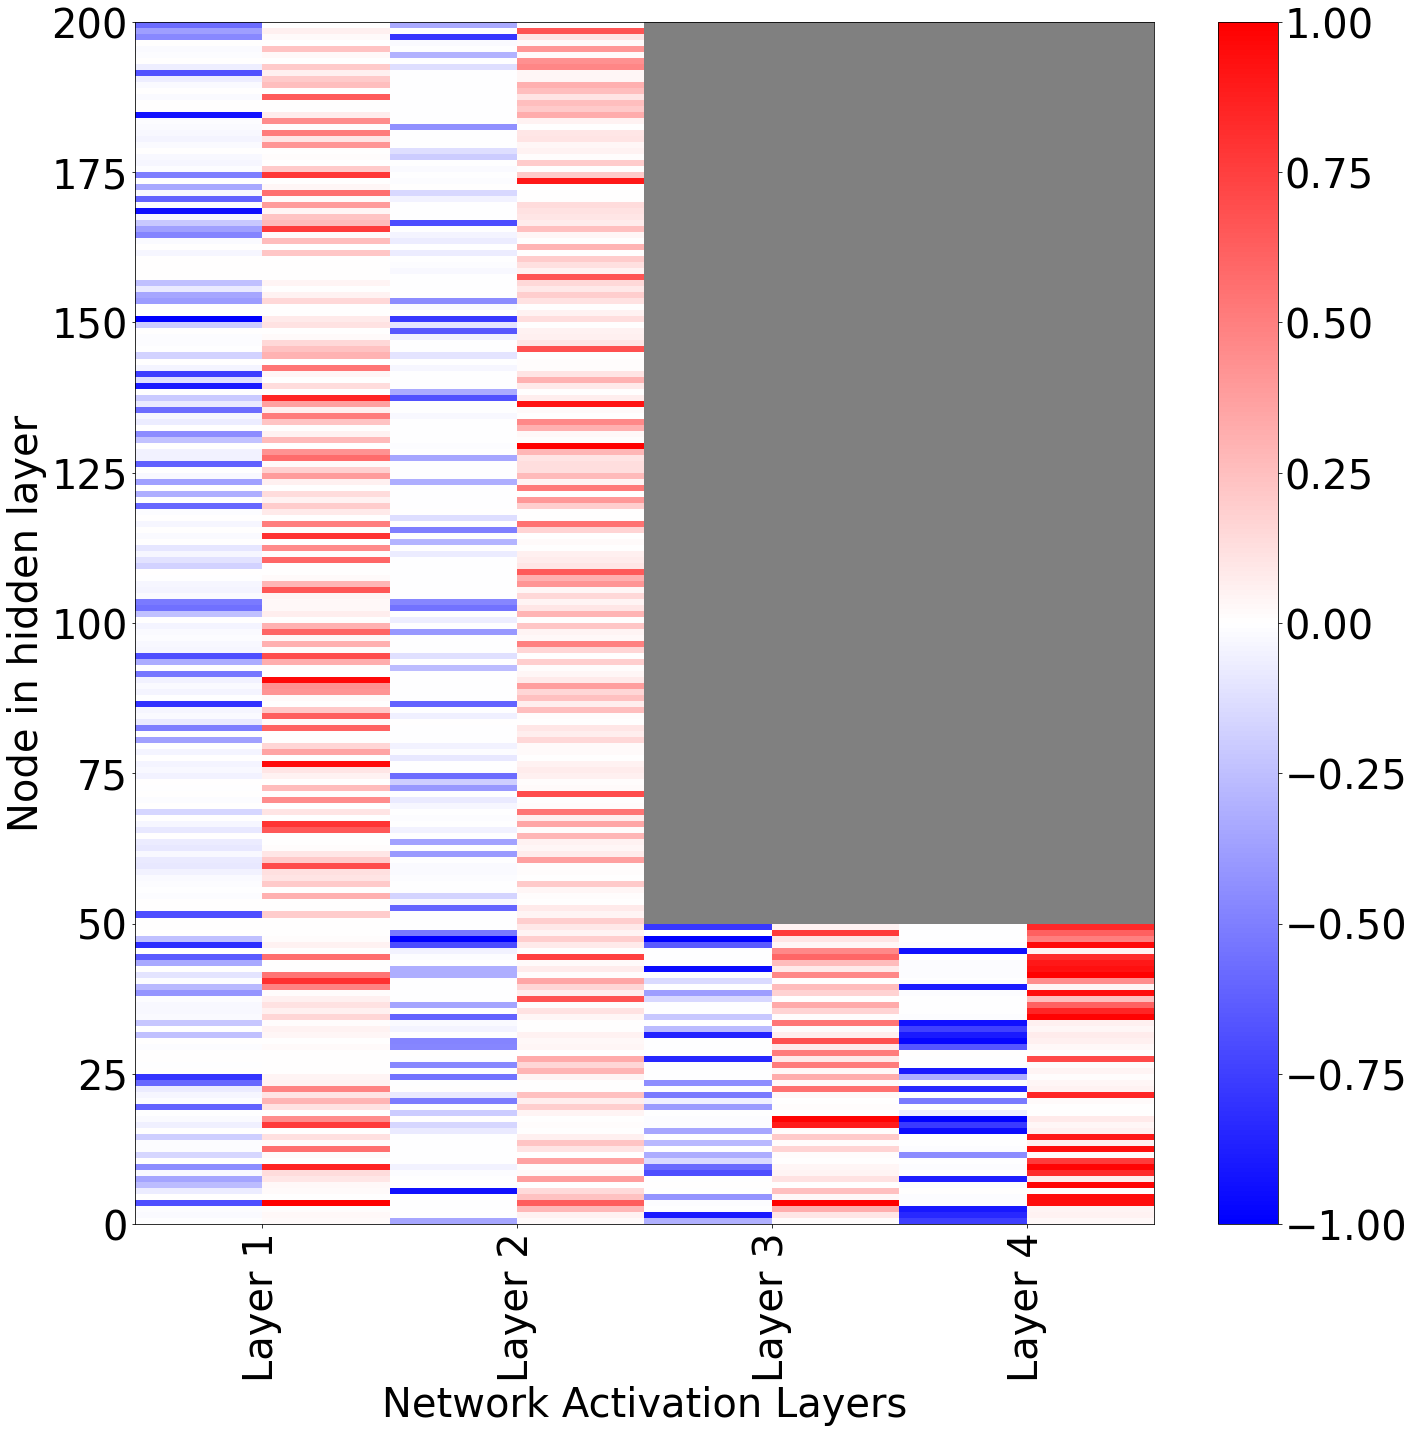

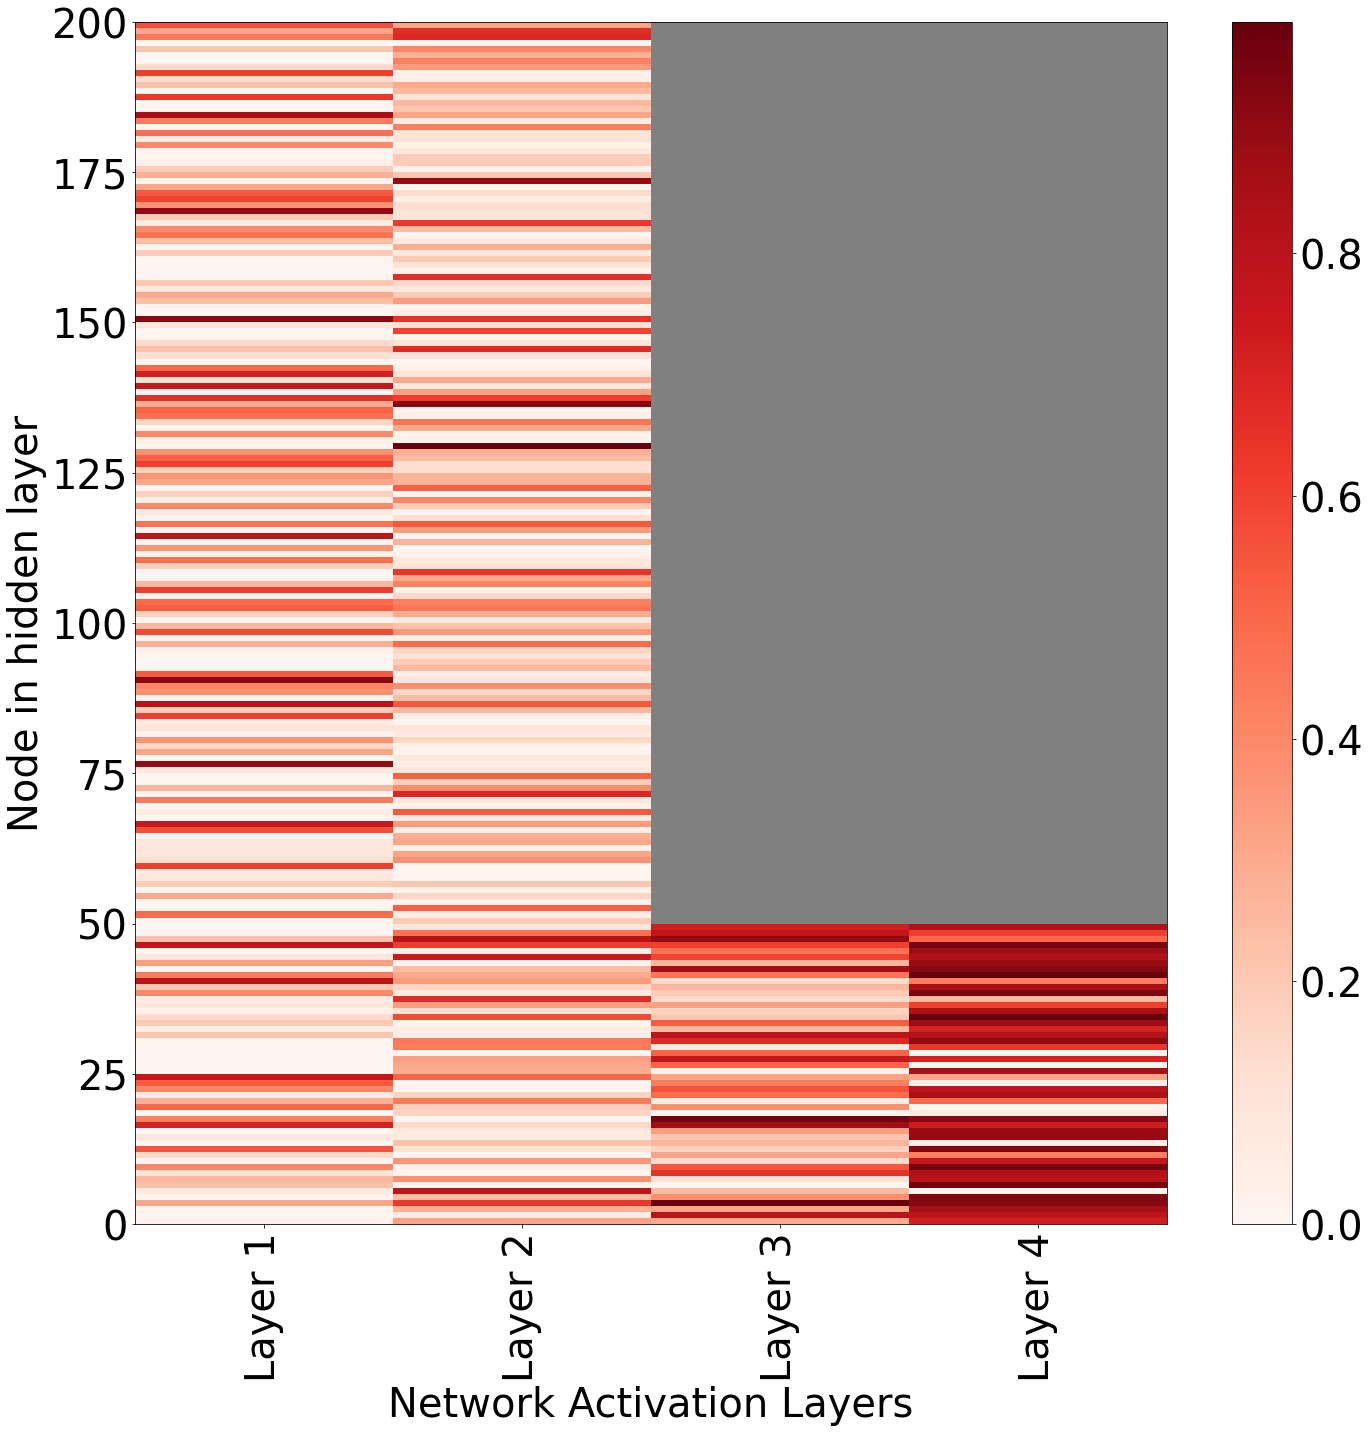

In [26]:
extra_names = ['']
sparsities ={}
for extra_name in extra_names:
    if tau_x_1:
        extra_name = 'tau_x_1'
    model_path = '../../models/Multi-Body/models/MultiBody' + str(N) + '-Subjettiness_mass' +str(use_jet_mass)+'_pt'+str(use_jet_pt)+'_'+ model_type + extra_name

    #loading model
    model = Model(N, use_jet_pt, use_jet_mass, tau_x_1).cuda()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    data = np.copy(feats)
    FiringMatrix_0, layer_tags = NeuronFiringEvaluator(model, data[labels[:,0]==1, :])
    FiringMatrix_1, layer_tags = NeuronFiringEvaluator(model, data[labels[:,1]==1, :])
    extra_name = extra_name if extra_name else 'baseline'
    s = ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag=extra_name, save=True)
    sparsities[extra_name]= s

In [27]:
for mode in sparsities:
    print(mode, sparsities[mode][2])

baseline 0.442


In [28]:
for f in FiringMatrix_1: 
    print(f.shape)

(200,)
(200,)
(200,)
(200,)


ptmass


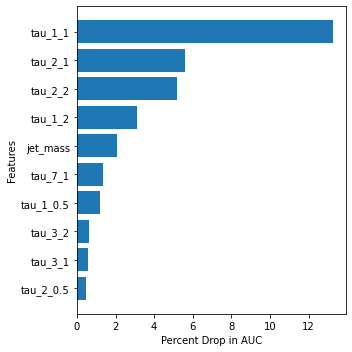

In [95]:
sorted_tags = []
sorted_vals = []
for val, tag in sorted(zip(dAUC_vals, feat_names), reverse = True)[:10]:
    sorted_tags.append(tag)
    sorted_vals.append(val)
    
tag = ('pt' if use_jet_pt else '') + ('mass' if use_jet_mass else '') + ('_' + extra_name if extra_name else '')
print(tag)
dAUC_chart(sorted_vals, sorted_tags, tag=tag, save=True)

In [96]:
def removeOutliers(x, outlierConstant=1.5):
    quantiles = np.nanquantile(x, (0.25, 0.75),axis=0)
    IQR = (quantiles[1]-quantiles[0])*1.5
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def plotmaker(data, tags, plot_type = 'abs_bar', part_dataset = 'bkg', save = False, modelnamesuffix = ""):
    modelnamesuffix = 'baseline' if not modelnamesuffix else modelnamesuffix
    if plot_type == 'abs_bar':
        data_no_outlier = removeOutliers(data)
        plt.figure(figsize=(5,5))
        abs_data = np.nanmean(np.abs(data_no_outlier), 0) #Takes mean across all jets
        df_rel = pd.DataFrame(dict(params=tags, rels=abs_data))
        df_rel_sorted = df_rel.sort_values('rels') #Sorts relevance values
        # creating the abs bar plot
        max_display = 10
        plt.barh('params', 'rels', data = df_rel_sorted.tail(max_display), color ='blue')
        plt.tight_layout()
        plt.xlabel("MAD Relevance Score", fontsize=10)
        plt.ylabel("Features", fontsize=10)
        plt.tick_params(axis='both', which='major', labelsize=10)
        # plt.title("TopoDNN Absolute Value "+type_set+" Delta LRP values")
        if save:
            plt.savefig("figures/dLRP_MB8S_{}_{}_absbar.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()
    if plot_type == 'box_whisker':
        plt.figure(figsize=(10,10))
        df_rel_total = pd.DataFrame(removeOutliers(data), columns=tags)
        sorted_index = df_rel_total.abs().mean().sort_values(ascending=False).index
        df_rel = pd.DataFrame(data, columns=tags)
        df_rel_total = df_rel[sorted_index[:20]]
        sns.boxplot(data=df_rel_total, orient='h', showfliers=False)
        #plt.title("TopoDNN "+type_set+" LRP Box and Whisker Distribution")
        plt.tight_layout()
        if save:
            plt.savefig("figures/dLRP_MB8S_{}_{}_boxwhisker.png".format(modelnamesuffix, part_dataset), 
                        dpi = 150, bbox_inches='tight')
        plt.show()

In [97]:
bkg_indices = labels[:,0] == 1
sig_indices = labels[:,0] == 0
dresult_presoftmax_bkg = []
dresult_presoftmax_sig = []
dresult_bkg = []
dresult_sig = []
for idx in range(len(feat_names)):
    dresult_presoftmax_bkg.append(dresult_presoftmax[idx][bkg_indices][:,0])
    dresult_presoftmax_sig.append(dresult_presoftmax[idx][sig_indices][:,1])
    dresult_bkg.append(dresult[idx][bkg_indices][:,0])
    dresult_sig.append(dresult[idx][sig_indices][:,1])

In [98]:
dresult_presoftmax_bkg = np.transpose(np.array(dresult_presoftmax_bkg))
dresult_presoftmax_sig = np.transpose(np.array(dresult_presoftmax_sig))
dresult_bkg = np.transpose(np.array(dresult_bkg))
dresult_sig = np.transpose(np.array(dresult_sig))

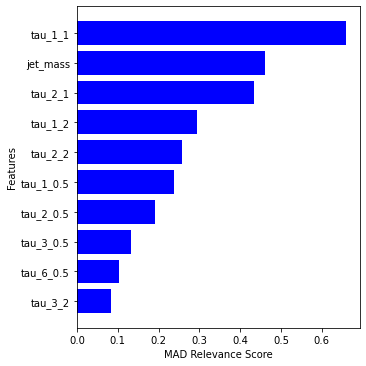

In [99]:
plotmaker(data = dresult_presoftmax_bkg, tags = feat_names, 
          plot_type = 'abs_bar', part_dataset = 'bkg', 
          save = True, modelnamesuffix = tag)

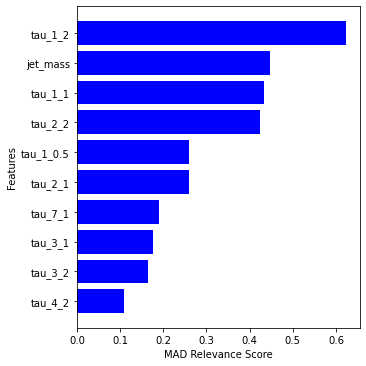

In [100]:
plotmaker(data = dresult_presoftmax_sig, tags = feat_names, 
          plot_type = 'abs_bar', part_dataset = 'sig', 
          save = True, modelnamesuffix = tag)